In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
batch_size = 32

In [37]:
# Define the transformations to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( mean=(0.1307,),std= (0.3081,))])

# Download the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Split the trainset into train and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

# Create data loaders for the train, validation, and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=os.cpu_count())
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=os.cpu_count())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=os.cpu_count(), drop_last=True)

In [38]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

class BetaVAE(nn.Module):
    def __init__(self, latent_dim, beta):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.fc1 = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, self.latent_dim)
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z
    
    def encode(self, x):
        x = self.encoder(x)
        mean = self.fc1(x)
        logvar = self.fc2(x)
        return mean, logvar
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + self.beta * kl_divergence
        return loss

In [39]:
betas = [10, 20]
lr = 2e-4
latent_dim = 20

In [40]:
def plot_latent_dimention(z, y, betas):
    fig, axs = plot.subplots(ncols=2, figsize=(15, 6))
    for idx, beta in enumerate(betas):
        df = pd.DataFrame()
        df["y"] = y[idx]
        df["comp-1"] = z[idx][:, 0]
        df["comp-2"] = z[idx][:, 1]
        
        sns.scatterplot(x="comp-1", y="comp-2", hue=y[idx].tolist(),
                        palette=sns.color_palette("hls", 10),
                        data=df, ax=axs[idx]).set(title=f"MNIST data T-SNE projection with beta: {beta}")


In [41]:
best_loss = np.inf
patience_count = 0
epochs = 50
patience = 10

def train(model, train_loader, val_loader, optimizer):
    patience_count = patience
    best_loss = np.inf
    for epoch in range(epochs):
        model.train()
        running_loss_train = 0.0
        running_loss_val = 0.0
        val_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar, z = model(data)
            loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()
        train_loss = np.mean(running_loss_train)
        print('Epoch: {} \t Training Loss: {:.3f}'.format(epoch+1, train_loss))
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                recon_x, mu, logvar, z = model(data)
                loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
                running_loss_val += loss.item()
            val_loss = np.mean(running_loss_val)
        if val_loss < best_loss:
            print('Epoch: {} \t Validation Loss decreased: {:.3f} --> {:.3f}'.format(epoch+1, best_loss, val_loss))
            best_loss = val_loss
            patience_count = patience
        else:
            patience_count -= 1
        if patience_count == 0:
            print('No improvement for Epoch: {} \t Early Stopping...'.format(patience))
            break

def test(model, test_loader, optimizer):
    patience_count = patience
    best_loss = np.inf
    model.eval()
    running_loss_test = 0.0
    latent_dimentions = []
    data_labels = []
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            recon_x, mu, logvar, z = model(data)
            loss = model.loss_function(recon_x= recon_x, x= data,mu= mu, logvar= logvar)
            latent_dimentions.append(z)
            data_labels.append(labels)
            running_loss_test += loss.item()
        test_loss = np.mean(running_loss_test)
        print('Testing Loss: {:.3f}'.format(test_loss))
    return torch.cat(latent_dimentions, dim=0), torch.cat(data_labels, dim=0)
    

In [42]:
labels = []
output = []
for beta in betas:
    print(f"Training started with beta: {beta}")
    model = BetaVAE(latent_dim=20, beta=beta).to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train(model= model, train_loader=train_loader, val_loader=val_loader, optimizer= optimizer)
    x, y = test(model= model, optimizer= optimizer,test_loader=test_loader)

    labels.append(y)
    
    ## Dimentionality reduction using TSNE
    tsne = TSNE(n_components=2, verbose=1)
    z = tsne.fit_transform(x.cpu())
    output.append(z)


Training started with beta: 10
Epoch: 1 	 Training Loss: -1030587230.859
Epoch: 1 	 Validation Loss decreased: inf --> -297845570.750
Epoch: 2 	 Training Loss: -1587819892.188
Epoch: 2 	 Validation Loss decreased: -297845570.750 --> -333943737.312
Epoch: 3 	 Training Loss: -1705608089.062
Epoch: 3 	 Validation Loss decreased: -333943737.312 --> -347814999.750
Epoch: 4 	 Training Loss: -1770070587.250
Epoch: 4 	 Validation Loss decreased: -347814999.750 --> -356521994.375
Epoch: 5 	 Training Loss: -1807798953.188
Epoch: 5 	 Validation Loss decreased: -356521994.375 --> -364528181.500
Epoch: 6 	 Training Loss: -1833658135.250
Epoch: 6 	 Validation Loss decreased: -364528181.500 --> -367648936.625
Epoch: 7 	 Training Loss: -1852111509.625
Epoch: 7 	 Validation Loss decreased: -367648936.625 --> -371556050.062
Epoch: 8 	 Training Loss: -1865860132.188
Epoch: 8 	 Validation Loss decreased: -371556050.062 --> -373622383.250
Epoch: 9 	 Training Loss: -1875629984.688
Epoch: 9 	 Validation Loss

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9984 samples in 1.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 1.270176
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.824890
[t-SNE] KL divergence after 1000 iterations: 2.411410
Training started with beta: 20
Epoch: 1 	 Training Loss: -972759559.787
Epoch: 1 	 Validation Loss decreased: inf --> -286

/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jaspreet/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9984 samples in 1.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 1.298172
[t-SNE] KL divergence after 50 iterations with early exaggeration: 96.426247
[t-SNE] KL divergence after 1000 iterations: 2.799669


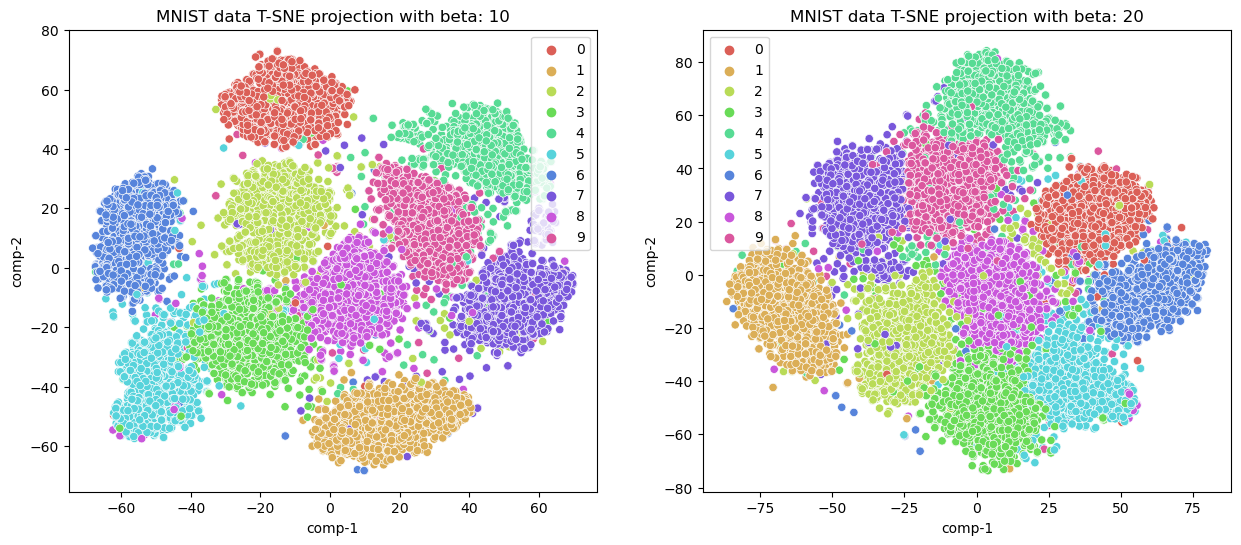

In [43]:
plot_latent_dimention(z=output,y=labels, betas= betas)
